<a href="https://colab.research.google.com/github/ritwiks9635/Tabular_Data_Projects_File/blob/main/FeatureSpace_advanced.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Timeseries classification from scratch**

## Introduction

This example shows how to do timeseries classification from scratch, starting from raw
CSV timeseries files on disk. We demonstrate the workflow on the FordA dataset from the
[UCR/UEA archive](https://www.cs.ucr.edu/%7Eeamonn/time_series_data_2018/).

In [ ]:
import keras
import numpy as np
import matplotlib.pyplot as plt

## Load the data: the FordA dataset

### Dataset description

The dataset we are using here is called FordA.
The data comes from the UCR archive.
The dataset contains 3601 training instances and another 1320 testing instances.
Each timeseries corresponds to a measurement of engine noise captured by a motor sensor.
For this task, the goal is to automatically detect the presence of a specific issue with
the engine. The problem is a balanced binary classification task. The full description of
this dataset can be found [here](http://www.j-wichard.de/publications/FordPaper.pdf).

### Read the TSV data

We will use the `FordA_TRAIN` file for training and the
`FordA_TEST` file for testing. The simplicity of this dataset
allows us to demonstrate effectively how to use ConvNets for timeseries classification.
In this file, the first column corresponds to the label.

In [ ]:
def readucr(filename):
    data = np.loadtxt(filename, delimiter="\t")
    y = data[:, 0]
    x = data[:, 1:]
    return x, y.astype(int)


root_url = "https://raw.githubusercontent.com/hfawaz/cd-diagram/master/FordA/"

x_train, y_train = readucr(root_url + "FordA_TRAIN.tsv")
x_test, y_test = readucr(root_url + "FordA_TEST.tsv")

## Visualize the data

Here we visualize one timeseries example for each class in the dataset.

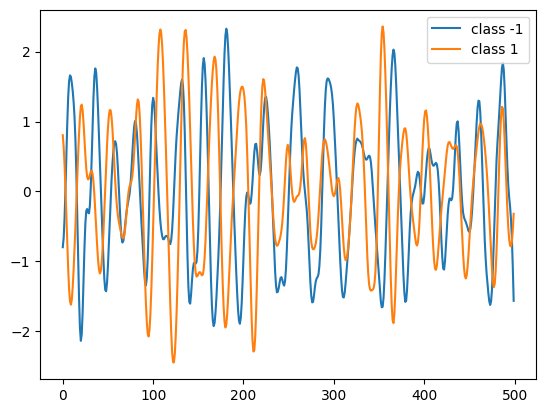

In [ ]:
classes = np.unique(np.concatenate((y_train, y_test), axis=0))

plt.figure()
for c in classes:
    c_x_train = x_train[y_train == c]
    plt.plot(c_x_train[0], label="class " + str(c))
plt.legend(loc="best")
plt.show()
plt.close()

## Standardize the data

Our timeseries are already in a single length (500). However, their values are
usually in various ranges. This is not ideal for a neural network;
in general we should seek to make the input values normalized.
For this specific dataset, the data is already z-normalized: each timeseries sample
has a mean equal to zero and a standard deviation equal to one. This type of
normalization is very common for timeseries classification problems, see
[Bagnall et al. (2016)](https://link.springer.com/article/10.1007/s10618-016-0483-9).

Note that the timeseries data used here are univariate, meaning we only have one channel
per timeseries example.
We will therefore transform the timeseries into a multivariate one with one channel
using a simple reshaping via numpy.
This will allow us to construct a model that is easily applicable to multivariate time
series.

In [ ]:
x_train.shape, x_test.shape

((3601, 500), (1320, 500))

In [ ]:
x_train = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))

Finally, in order to use `sparse_categorical_crossentropy`, we will have to count
the number of classes beforehand.

In [ ]:
num_classes = len(np.unique(y_train))
num_classes

2

Now we shuffle the training set because we will be using the `validation_split` option
later when training.

In [ ]:
idx = np.random.permutation(len(x_train))

x_train = x_train[idx]
y_train = y_train[idx]

Standardize the labels to positive integers.
The expected labels will then be 0 and 1.

In [ ]:
y_train[y_train == -1] = 0
y_test[y_test == -1] = 0

In [ ]:
y_train

array([0, 0, 1, ..., 0, 1, 1])

## Build a model

We build a Fully Convolutional Neural Network originally proposed in
[this paper](https://arxiv.org/abs/1611.06455).
The implementation is based on the TF 2 version provided
[here](https://github.com/hfawaz/dl-4-tsc/).
The following hyperparameters (kernel_size, filters, the usage of BatchNorm) were found
via random search using [KerasTuner](https://github.com/keras-team/keras-tuner).

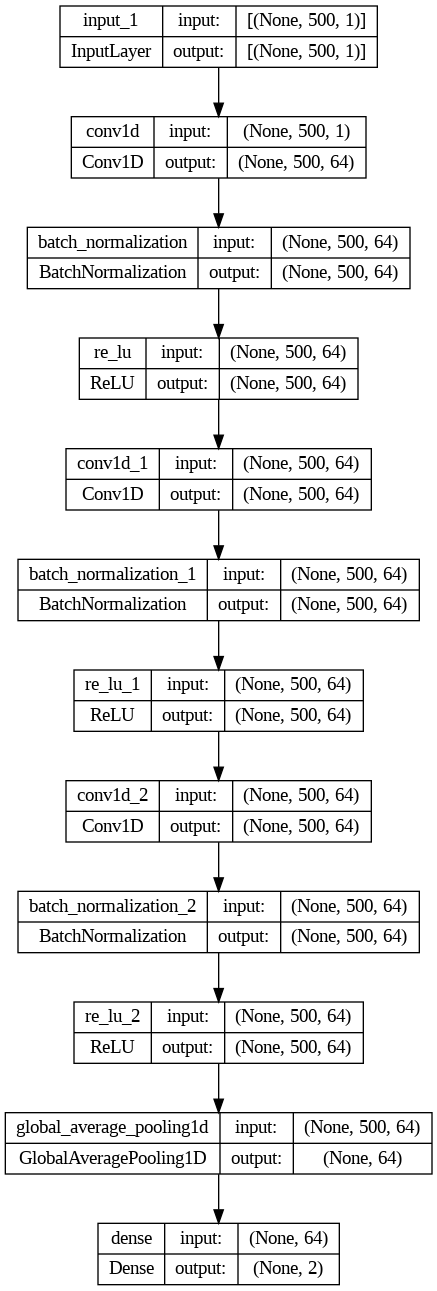

In [ ]:
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(num_classes, activation="softmax")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=x_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 500
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["sparse_categorical_accuracy"],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
90/90 [==============================] - 12s 110ms/step - loss: 0.5371 - sparse_categorical_accuracy: 0.7181 - val_loss: 0.7275 - val_sparse_categorical_accuracy: 0.4813 - lr: 0.0010
Epoch 2/500
90/90 [==============================] - 10s 111ms/step - loss: 0.4389 - sparse_categorical_accuracy: 0.7726 - val_loss: 0.8238 - val_sparse_categorical_accuracy: 0.4813 - lr: 0.0010
Epoch 3/500
90/90 [==============================] - 10s 110ms/step - loss: 0.4223 - sparse_categorical_accuracy: 0.7882 - val_loss: 0.7423 - val_sparse_categorical_accuracy: 0.4813 - lr: 0.0010
Epoch 4/500
90/90 [==============================] - 9s 102ms/step - loss: 0.4259 - sparse_categorical_accuracy: 0.7830 - val_loss: 0.6960 - val_sparse_categorical_accuracy: 0.5659 - lr: 0.0010
Epoch 5/500
90/90 [==============================] - 10s 114ms/step - loss: 0.4044 - sparse_categorical_accuracy: 0.7976 - val_loss: 0.6221 - val_sparse_categorical_accuracy: 0.5992 - lr: 0.0010
Epoch 6/500
90/90 [=======

## Evaluate model on test data

In [ ]:
model = keras.models.load_model("best_model.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

## Plot the model's training and validation loss

In [ ]:
metric = "sparse_categorical_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()

We can see how the training accuracy reaches almost 0.95 after 100 epochs.
However, by observing the validation accuracy we can see how the network still needs
training until it reaches almost 0.97 for both the validation and the training accuracy
after 200 epochs. Beyond the 200th epoch, if we continue on training, the validation
accuracy will start decreasing while the training accuracy will continue on increasing:
the model starts overfitting.